# LightGBM GPU Build Installation

* Poor accuracy

* Didn't speedup at all(even after using recommended settings)

[https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html#:~:text=In%20LightGBM%2C%20the%20main%20computation,ranking%2C%20regression%2C%20etc).]

In [1]:
#%%bash
#apt-get install --no-install-recommends git cmake build-essential libboost-dev libboost-system-dev libboost-filesystem-dev
#git clone --recursive https://github.com/microsoft/LightGBM
#cd LightGBM
#mkdir build
#cd build
#cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
#make -j$(nproc)
#cd ..
#cd LightGBM/python-package/;python3 setup.py install --precompile
#mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
#rm -r LightGBM

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,RobustScaler
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids , NearMiss

from tqdm.notebook import tqdm ,tnrange

/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__results__.html
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__notebook__.ipynb
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/combined.csv
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/custom.css
/kaggle/input/lets-get-rid-of-the-patients-feature-engineering/__output__.json
/kaggle/input/healthcareanalyticsii/sample_submission.csv
/kaggle/input/healthcareanalyticsii/train_data_dict.csv
/kaggle/input/healthcareanalyticsii/test.csv
/kaggle/input/healthcareanalyticsii/train.csv


In [3]:
train_data = pd.read_csv('../input/healthcareanalyticsii/train.csv')
test_data = pd.read_csv('../input/healthcareanalyticsii/test.csv')

In [4]:
print(train_data.shape)
train_data.head()

(318438, 18)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [5]:
print(test_data.shape)
test_data.head()

(137057, 17)


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [6]:
def nullColumns(train_data):
    list_of_nullcolumns =[]
    for column in train_data.columns:
        total= train_data[column].isna().sum()
        try:
            if total !=0:
                print('Total Na values is {0} for column {1}' .format(total, column))
                list_of_nullcolumns.append(column)
        except:
            print(column,"-----",total)
    print('\n')
    return list_of_nullcolumns


def percentMissingFeature(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return data_na


def plotMissingFeature(data_na):
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    if(data_na.empty ==False):
        sns.barplot(x=data_na.index, y=data_na)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)

In [7]:
print('train data')
print(nullColumns(train_data))
print(percentMissingFeature(train_data))
print('\n')
print('test_data')
print(nullColumns(test_data))
print(percentMissingFeature(test_data))

train data
Total Na values is 113 for column Bed Grade
Total Na values is 4532 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.423197
Bed Grade            0.035486
dtype: float64


test_data
Total Na values is 35 for column Bed Grade
Total Na values is 2157 for column City_Code_Patient


['Bed Grade', 'City_Code_Patient']
City_Code_Patient    1.573798
Bed Grade            0.025537
dtype: float64


Text(0.5, 1.0, 'Stay')

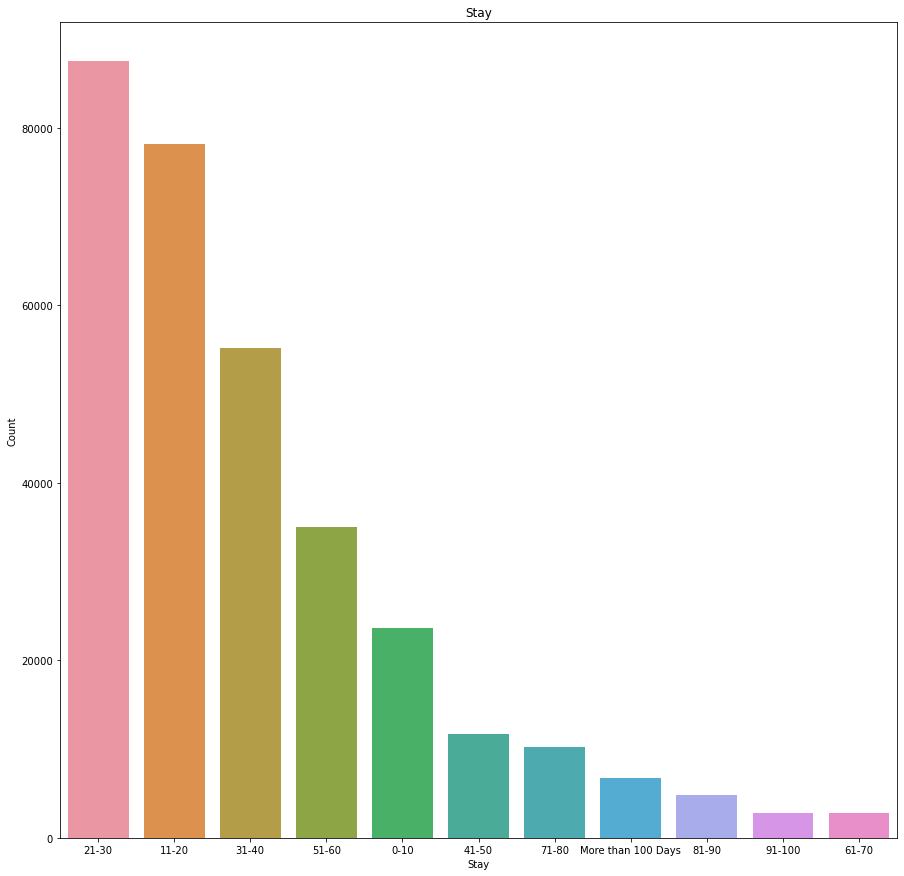

In [8]:
stay = train_data.loc[:,"Stay"].value_counts().rename('Count')
plt.xlabel("Stay")
plt.ylabel('Count')
sns.barplot(stay.index , stay.values).set_title('Stay')

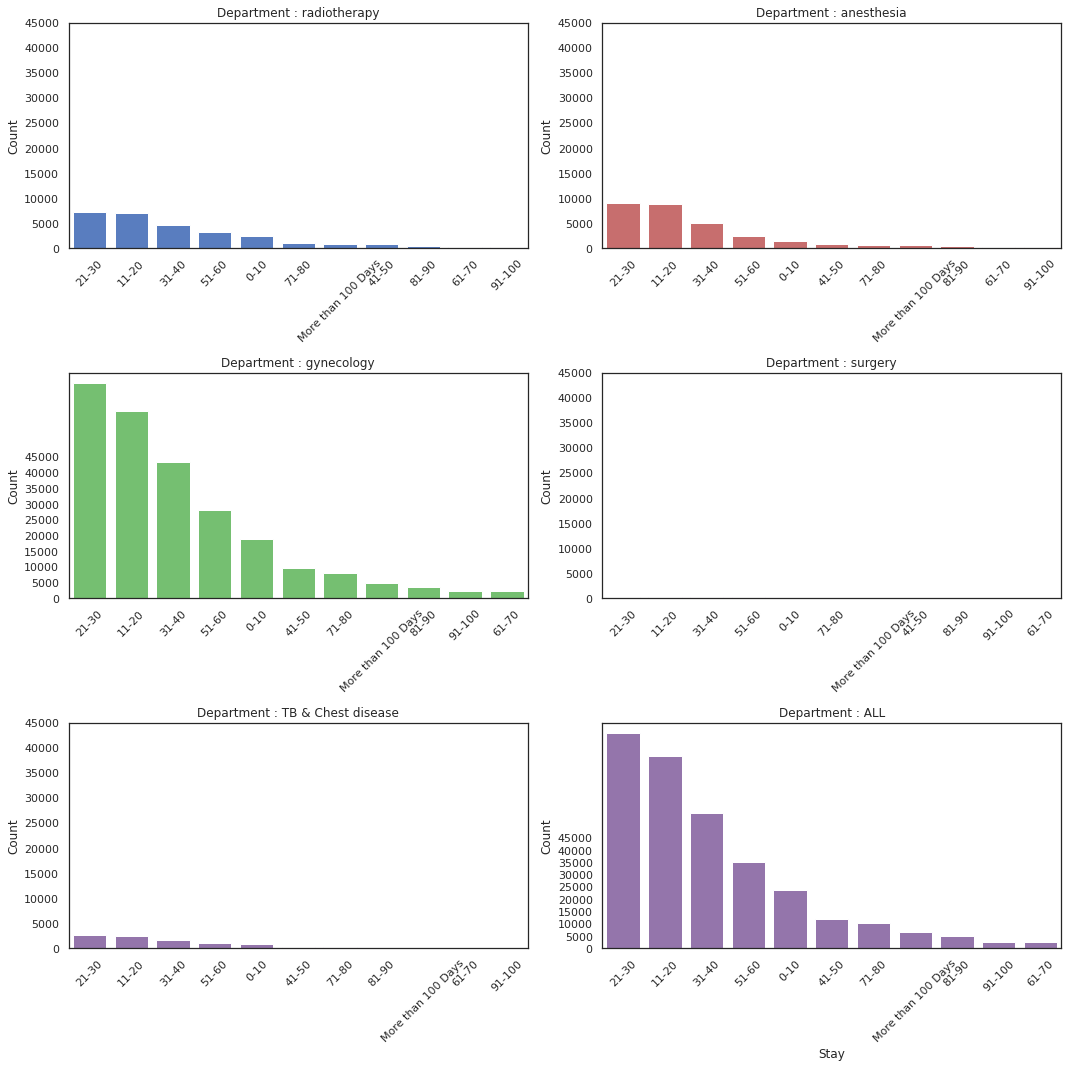

In [9]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 2, figsize=(15, 15))

radiotherapy = train_data[train_data.Department =='radiotherapy']["Stay"].value_counts().rename('Count')

anesthesia = train_data[train_data.Department =='anesthesia']["Stay"].value_counts().rename('Count')

gynecology = train_data[train_data.Department =='gynecology']["Stay"].value_counts().rename('Count')

surgery = train_data[train_data.Department =='surgery']["Stay"].value_counts().rename('Count')

tb = train_data[train_data.Department =='TB & Chest disease']["Stay"].value_counts().rename('Count')

sns.barplot(radiotherapy.index,radiotherapy,  color="b", ax=axes[0, 0]).set_title('Department : radiotherapy')

sns.barplot(anesthesia.index,anesthesia,   color="r", ax=axes[0, 1]).set_title('Department : anesthesia')

sns.barplot(gynecology.index,gynecology,  color="g", ax=axes[1, 0]).set_title('Department : gynecology')

sns.barplot(surgery.index,surgery, color="m", ax=axes[1, 1]).set_title('Department : surgery')

sns.barplot(tb.index,tb, color="m", ax=axes[2, 0]).set_title('Department : TB & Chest disease')

sns.barplot(stay.index,stay, color="m", ax=axes[2, 1]).set_title('Department : ALL')

plt.xlabel("Stay")

plt.setp(axes,yticks = np.arange(0,50000,5000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()


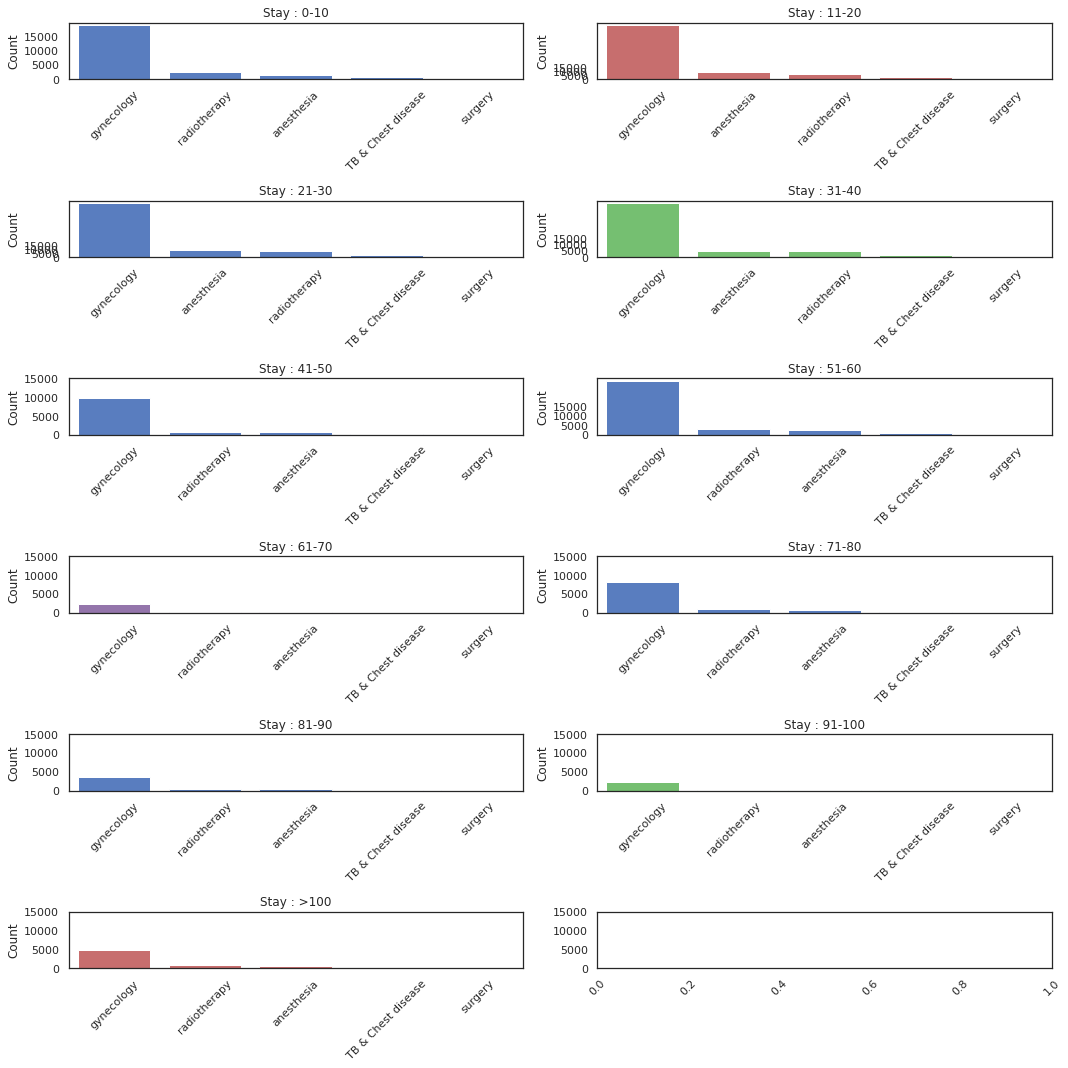

In [10]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(6, 2, figsize=(15, 15))

stay0 = train_data[train_data.Stay =='0-10']["Department"].value_counts().rename('Count')

stay1 = train_data[train_data.Stay =='11-20']["Department"].value_counts().rename('Count')

stay2 = train_data[train_data.Stay =='21-30']["Department"].value_counts().rename('Count')

stay3 = train_data[train_data.Stay =='31-40']["Department"].value_counts().rename('Count')

stay4 = train_data[train_data.Stay =='41-50']["Department"].value_counts().rename('Count')

stay5 = train_data[train_data.Stay =='51-60']["Department"].value_counts().rename('Count')

stay6 = train_data[train_data.Stay =='61-70']["Department"].value_counts().rename('Count')

stay7 = train_data[train_data.Stay =='71-80']["Department"].value_counts().rename('Count')

stay8 = train_data[train_data.Stay =='81-90']["Department"].value_counts().rename('Count')

stay9 = train_data[train_data.Stay =='91-100']["Department"].value_counts().rename('Count')

stay10 = train_data[train_data.Stay =='More than 100 Days']["Department"].value_counts().rename('Count')

sns.barplot(stay0.index,stay0,  color="b", ax=axes[0, 0]).set_title('Stay : 0-10')
                   
sns.barplot(stay1.index,stay2,  color="r", ax=axes[0, 1]).set_title('Stay : 11-20')

sns.barplot(stay2.index,stay2,  color="b", ax=axes[1, 0]).set_title('Stay : 21-30')

sns.barplot(stay3.index,stay3,  color="g", ax=axes[1, 1]).set_title('Stay : 31-40')

sns.barplot(stay4.index,stay4,  color="b", ax=axes[2, 0]).set_title('Stay : 41-50')

sns.barplot(stay5.index,stay5,  color="b", ax=axes[2, 1]).set_title('Stay : 51-60')

sns.barplot(stay6.index,stay6,  color="m", ax=axes[3, 0]).set_title('Stay : 61-70')

sns.barplot(stay7.index,stay7, color="b", ax=axes[3, 1]).set_title('Stay : 71-80')

sns.barplot(stay8.index,stay8,  color="b", ax=axes[4, 0]).set_title('Stay : 81-90')

sns.barplot(stay9.index,stay9,  color="g", ax=axes[4, 1]).set_title('Stay : 91-100')

sns.barplot(stay10.index,stay10, color="r", ax=axes[5, 0]).set_title('Stay : >100')

plt.setp(axes, yticks = np.arange(0,20000,5000))


for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

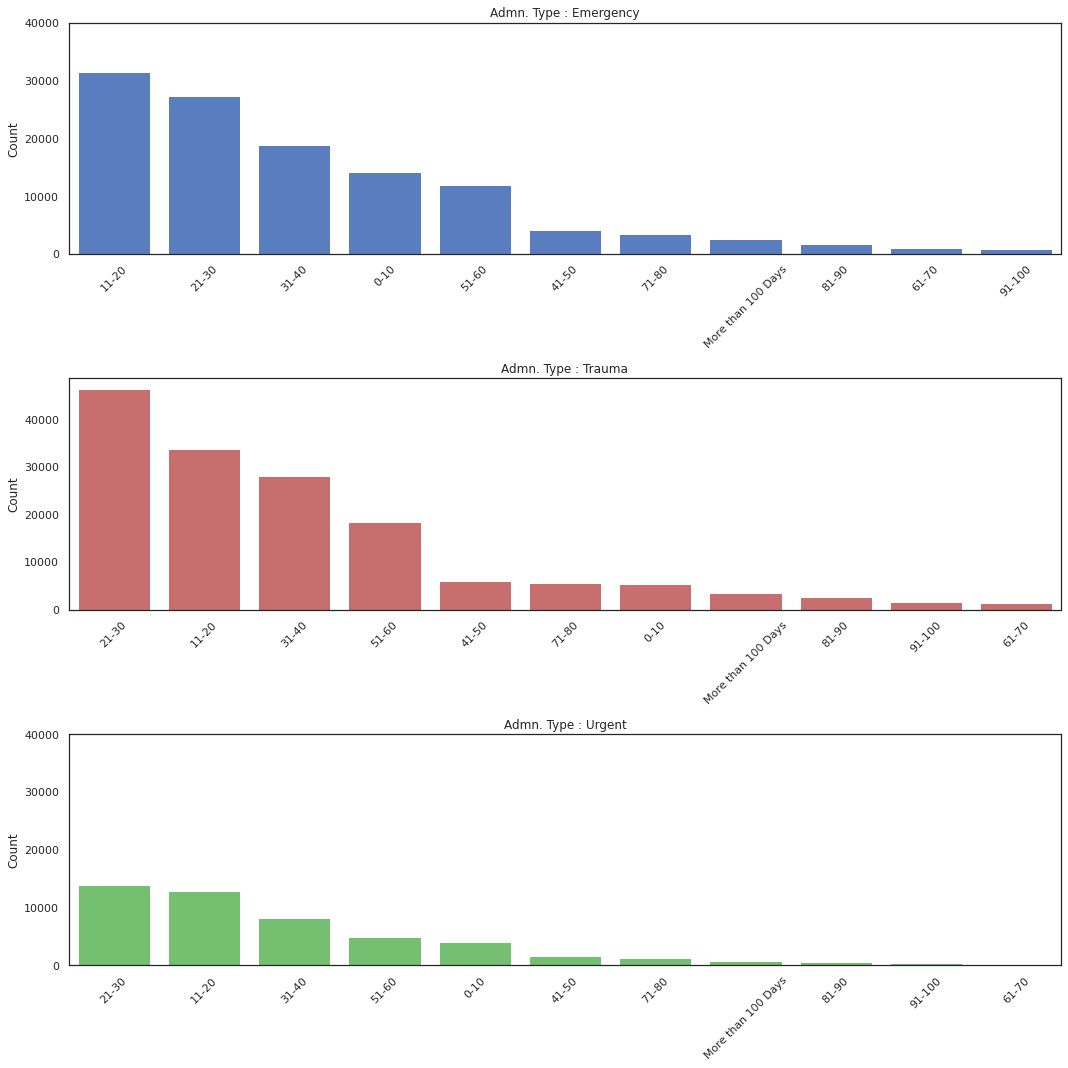

In [11]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(15, 15))

emergency = train_data[train_data['Type of Admission'] =='Emergency']["Stay"].value_counts().rename('Count')

trauma = train_data[train_data['Type of Admission'] =='Trauma']["Stay"].value_counts().rename('Count')

urgent = train_data[train_data['Type of Admission'] =='Urgent']["Stay"].value_counts().rename('Count')

sns.barplot(emergency.index,emergency,  color="b", ax=axes[0]).set_title('Admn. Type : Emergency')

sns.barplot(trauma.index,trauma,   color="r", ax=axes[1]).set_title('Admn. Type : Trauma')

sns.barplot(urgent.index,urgent,  color="g", ax=axes[2]).set_title('Admn. Type : Urgent')

plt.setp(axes, yticks = np.arange(0,50000,10000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=45)

plt.tight_layout()

In [12]:
train_data['City_Code_Patient'] = train_data['City_Code_Patient'].fillna(-1)
train_data['Bed Grade'] = train_data['Bed Grade'].fillna(-1)

In [13]:
test_data['City_Code_Patient'] = test_data['City_Code_Patient'].fillna(-1)
test_data['Bed Grade'] = test_data['Bed Grade'].fillna(-1)

In [14]:
cat_cols = ['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code'
            ,'Department','Ward_Type','Ward_Facility_Code','Bed Grade','City_Code_Patient',
           # 'Type of Admission','Severity of Illness',
            'Age']

In [15]:
label = 'Stay'

In [16]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        le = LabelEncoder()
        
        le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())
        
        train_df[col] = le.transform(train_df[[col]])
        
        test_df[col] = le.transform(test_df[[col]])

        le_dict[col] = le

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    train_df['Type of Admission'] = train_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    train_df['Severity of Illness'] = train_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    test_df['Type of Admission'] = test_df['Type of Admission'].map({'Urgent':0,'Emergency':1,'Trauma':2})
    
    test_df['Severity of Illness'] = test_df['Severity of Illness'].map({'Minor':0,'Moderate':1,'Extreme':2})
    
    return train_df, test_df, le_dict

In [17]:
def feature_importance(model, X_train):

    fI = model.booster_.feature_importance(importance_type='gain')
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

In [18]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_cols)

In [19]:
#After Feature Engineering
# https://www.kaggle.com/gcspkmdr/lets-get-rid-of-the-patients-feature-engineering

combined_data = pd.read_csv('../input/lets-get-rid-of-the-patients-feature-engineering/combined.csv')

In [20]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [21]:
train_df.drop(columns = ['case_id','train','patientid','Hospital_code',
                         'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)

target = train_df.pop('Stay')

test_df.drop(columns = ['case_id','train','Stay','patientid','Hospital_code',
                        'Hospital_type_code','City_Code_Hospital','Ward_Facility_Code'],inplace = True)

In [22]:
cat_features = ['Hospital_region_code','Department','Ward_Type','Bed Grade','City_Code_Patient','Type of Admission','Severity of Illness','Age']

for f in cat_features:
    
    train_df[f] = train_df[f].astype('category')
    
    test_df[f] = test_df[f].astype('category')

# Cross Validation
![](https://4.bp.blogspot.com/-wpr6O3EBAfU/WbHyt6UCOVI/AAAAAAAAjPw/Y1DaO6qcV8oDYjJHzJ1PaPB2EXHmYtBBQCLcBGAs/s1600/%25E6%2593%25B7%25E5%258F%2596.JPG)

* **The CV score generated using the methodology shown in the above figure is a better indicator of model performance than public LB**

Fold 0
 rows of train = 175140 rows of holdout = 143298
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49293
[200]	valid_0's multi_logloss: 1.48208
[300]	valid_0's multi_logloss: 1.47918
[400]	valid_0's multi_logloss: 1.47752
Early stopping, best iteration is:
[411]	valid_0's multi_logloss: 1.47741
LGB Val CV= 43.42628647992296
####################################################################################################
[  1880.16649318  34411.28130237   6421.07418551  99985.32230271
  22939.06196594  36952.46600032  31365.07461394  15404.07457515
 110552.03770348  17150.65622967  58400.72510907   6748.43777105
   7280.33605418   7567.19697399  19592.4158596    4052.44886257
  12304.22667244   7476.42216216   7655.95580507  29463.3289606
   9047.23782209   6652.73850045   4900.00576681  18944.30855991
  26505.0020871   17738.21192187  17383.52684654   6807.14567541
  10637.91052922   3059.29847436   2571.0253164    5819.24591875
   

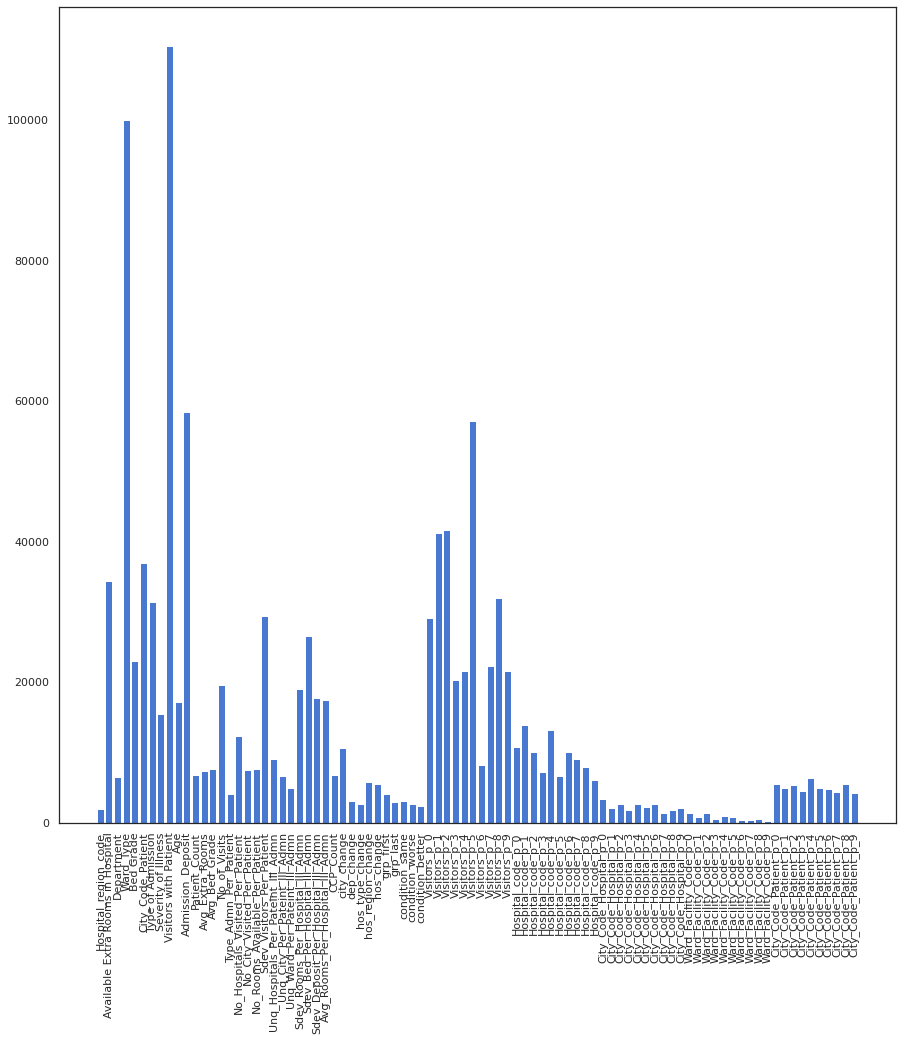

Fold 1
 rows of train = 175140 rows of holdout = 143298
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49387
[200]	valid_0's multi_logloss: 1.48183
[300]	valid_0's multi_logloss: 1.47813
[400]	valid_0's multi_logloss: 1.47667
[500]	valid_0's multi_logloss: 1.47614
Early stopping, best iteration is:
[494]	valid_0's multi_logloss: 1.47611
LGB Val CV= 43.50374743541431
####################################################################################################
Fold 2
 rows of train = 175140 rows of holdout = 143298
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49173
[200]	valid_0's multi_logloss: 1.48019
[300]	valid_0's multi_logloss: 1.47706
[400]	valid_0's multi_logloss: 1.476
Early stopping, best iteration is:
[425]	valid_0's multi_logloss: 1.47587
LGB Val CV= 43.58399977668913
####################################################################################################
Fold 3


In [23]:
%%time

##LightGBM

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.45 ,random_state=1)

for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):
    
    print('Fold',i)
    
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
    
    clf = lgb.LGBMClassifier(n_estimators=10000,
                             max_depth=8,
                             learning_rate=0.1,
                             subsample=0.85,
                             colsample_bytree=0.5,
                             #device ='gpu',
                             #gpu_platform_id = 0,
                             #gpu_device_id =  0,
                             objective ='multiclass',
                             #max_bin=63,
                             #gpu_use_dp=False,
                             random_state = 1,
                             #categorical_columns = cat_features
                            )        
    
    h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                verbose=100,eval_metric=['multi_logloss'],
                early_stopping_rounds=50)
    
    acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(clf.predict_proba(X_train_cv.iloc[idxV]),axis =1))*100
    
    scores.append(acc)

    avg_loss.append(clf.best_score_['valid_0']['multi_logloss'])
    
    print ('LGB Val CV=',acc)
    
    print('#'*100)
    
    if i==0:
        feature_importance(clf,X_train_cv)

print("Multi Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

# Model Building

In [24]:
trees = 5

seeds = [32,432,73]

submission = pd.read_csv('../input/healthcareanalyticsii/sample_submission.csv')

probs = np.zeros(shape=(len(test_df),11))

submission_probs = pd.DataFrame(columns = ['case_id'] + list(le_dict['Stay'].classes_))

submission_probs.iloc[:,0] = submission.iloc[:,0]

submission_probs.iloc[:,1:] = 0

In [25]:
%%time

##LightGBM

#groups = train_df['patientid'].values

scores = []

avg_loss = []

submission_name = [] 

X_train_cv,y_train_cv = train_df.copy(), target.copy()

for seed in tnrange(len(seeds)):

    sssf = StratifiedShuffleSplit(n_splits=5, test_size = 0.3 ,random_state=seeds[seed])

    for j, (idxT, idxV) in tqdm(enumerate(sssf.split(X_train_cv, y_train_cv))):

        print('Fold',j)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        model_lgb = [0] *trees

        for i in tnrange(trees):

            print('Tree',i)

            model_lgb[i] = lgb.LGBMClassifier(n_estimators=1000,
                                     max_depth=8,
                                     learning_rate=0.1,
                                     subsample=0.8,
                                     colsample_bytree=0.5,
                                     #device ='gpu',
                                     #gpu_platform_id = 0,
                                     #gpu_device_id =  0,
                                     objective ='multiclass',
                                     random_state = i*27
                                    )        

            model_lgb[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                        eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                        verbose=100,eval_metric=['multi_logloss'],
                        early_stopping_rounds=50)

            probs_file_name = 'probs_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            submisssion_file_name  = 'submission_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            model_lgb_probs = model_lgb[i].predict_proba(test_df)
            
            submission_probs.iloc[:,1:] = model_lgb_probs
            
            # probablity file per seed per split per tree
            submission_probs.to_csv(probs_file_name,index = False)
            
            submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(model_lgb_probs,axis =1))
            
            # submission file per seed per split per tree
            submission.to_csv(submisssion_file_name,index =False)
            
            probs += model_lgb_probs
            
            acc = accuracy_score(y_train_cv.iloc[idxV],np.argmax(model_lgb[i].predict_proba(X_train_cv.iloc[idxV]),axis =1))*100
            
            scores.append(acc)
            
            submission_name.append(submisssion_file_name)
            
            avg_loss.append(model_lgb[i].best_score_['valid_0']['multi_logloss'])

            #print ('LGB Accuracy Split =',acc)
            
            print('#'*100)
    

print("Average Multi Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

#print('%.3f (%.3f)' % (np.array(scores).mean(), np.array(scores).std()))

Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48941
[200]	valid_0's multi_logloss: 1.47622
[300]	valid_0's multi_logloss: 1.47218
[400]	valid_0's multi_logloss: 1.47027
[500]	valid_0's multi_logloss: 1.46922
[600]	valid_0's multi_logloss: 1.46895
[700]	valid_0's multi_logloss: 1.469
Early stopping, best iteration is:
[673]	valid_0's multi_logloss: 1.46879
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48947
[200]	valid_0's multi_logloss: 1.47608
[300]	valid_0's multi_logloss: 1.47231
[400]	valid_0's multi_logloss: 1.47041
[500]	valid_0's multi_logloss: 1.46922
[600]	valid_0's multi_logloss: 1.46882
Early stopping, best iteration is:
[606]	valid_0's multi_logloss: 1.46876
####################################################################################################
Tree 2
Tr

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49369
[200]	valid_0's multi_logloss: 1.48093
[300]	valid_0's multi_logloss: 1.47664
[400]	valid_0's multi_logloss: 1.47478
[500]	valid_0's multi_logloss: 1.47375
[600]	valid_0's multi_logloss: 1.47345
Early stopping, best iteration is:
[641]	valid_0's multi_logloss: 1.47319
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49356
[200]	valid_0's multi_logloss: 1.48047
[300]	valid_0's multi_logloss: 1.47657
[400]	valid_0's multi_logloss: 1.4747
[500]	valid_0's multi_logloss: 1.47374
Early stopping, best iteration is:
[541]	valid_0's multi_logloss: 1.47356
####################################################################################################
Tree 2
Training until validation scores don't improve for 50 rounds
[100]	valid_0's mu

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49089
[200]	valid_0's multi_logloss: 1.47795
[300]	valid_0's multi_logloss: 1.47394
[400]	valid_0's multi_logloss: 1.47195
[500]	valid_0's multi_logloss: 1.4708
[600]	valid_0's multi_logloss: 1.47049
Early stopping, best iteration is:
[589]	valid_0's multi_logloss: 1.47039
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.4916
[200]	valid_0's multi_logloss: 1.47807
[300]	valid_0's multi_logloss: 1.47397
[400]	valid_0's multi_logloss: 1.47213
[500]	valid_0's multi_logloss: 1.47122
[600]	valid_0's multi_logloss: 1.47102
Early stopping, best iteration is:
[561]	valid_0's multi_logloss: 1.47086
####################################################################################################
Tree 2
Training until validation scores don't im

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49067
[200]	valid_0's multi_logloss: 1.47714
[300]	valid_0's multi_logloss: 1.47308
[400]	valid_0's multi_logloss: 1.47108
[500]	valid_0's multi_logloss: 1.47014
[600]	valid_0's multi_logloss: 1.46963
Early stopping, best iteration is:
[640]	valid_0's multi_logloss: 1.46948
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49033
[200]	valid_0's multi_logloss: 1.47682
[300]	valid_0's multi_logloss: 1.47271
[400]	valid_0's multi_logloss: 1.47042
[500]	valid_0's multi_logloss: 1.46909
[600]	valid_0's multi_logloss: 1.46861
Early stopping, best iteration is:
[588]	valid_0's multi_logloss: 1.46852
####################################################################################################
Tree 2
Training until validation scores don't 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48942
[200]	valid_0's multi_logloss: 1.47627
[300]	valid_0's multi_logloss: 1.47232
[400]	valid_0's multi_logloss: 1.47001
[500]	valid_0's multi_logloss: 1.46902
[600]	valid_0's multi_logloss: 1.46864
Early stopping, best iteration is:
[638]	valid_0's multi_logloss: 1.46847
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48937
[200]	valid_0's multi_logloss: 1.47568
[300]	valid_0's multi_logloss: 1.47189
[400]	valid_0's multi_logloss: 1.47004
[500]	valid_0's multi_logloss: 1.46878
[600]	valid_0's multi_logloss: 1.46804
Early stopping, best iteration is:
[608]	valid_0's multi_logloss: 1.46793
####################################################################################################
Tree 2
Training until validation scores don't 

Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49001
[200]	valid_0's multi_logloss: 1.47746
[300]	valid_0's multi_logloss: 1.47368
[400]	valid_0's multi_logloss: 1.47121
[500]	valid_0's multi_logloss: 1.47007
[600]	valid_0's multi_logloss: 1.46979
Early stopping, best iteration is:
[628]	valid_0's multi_logloss: 1.46964
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49093
[200]	valid_0's multi_logloss: 1.47762
[300]	valid_0's multi_logloss: 1.47351
[400]	valid_0's multi_logloss: 1.47128
[500]	valid_0's multi_logloss: 1.46979
[600]	valid_0's multi_logloss: 1.46948
Early stopping, best iteration is:
[569]	valid_0's multi_logloss: 1.46941
####################################################################################################
Tree 2
Training until validation scores don't 

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49086
[200]	valid_0's multi_logloss: 1.47755
[300]	valid_0's multi_logloss: 1.47333
[400]	valid_0's multi_logloss: 1.47089
[500]	valid_0's multi_logloss: 1.46966
[600]	valid_0's multi_logloss: 1.46892
Early stopping, best iteration is:
[600]	valid_0's multi_logloss: 1.46892
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49128
[200]	valid_0's multi_logloss: 1.4778
[300]	valid_0's multi_logloss: 1.47378
[400]	valid_0's multi_logloss: 1.47139
[500]	valid_0's multi_logloss: 1.47024
[600]	valid_0's multi_logloss: 1.46994
Early stopping, best iteration is:
[613]	valid_0's multi_logloss: 1.4699
####################################################################################################
Tree 2
Training until validation scores don't im

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48898
[200]	valid_0's multi_logloss: 1.47507
[300]	valid_0's multi_logloss: 1.47063
[400]	valid_0's multi_logloss: 1.46829
[500]	valid_0's multi_logloss: 1.46711
[600]	valid_0's multi_logloss: 1.46669
Early stopping, best iteration is:
[631]	valid_0's multi_logloss: 1.46649
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48955
[200]	valid_0's multi_logloss: 1.47531
[300]	valid_0's multi_logloss: 1.47102
[400]	valid_0's multi_logloss: 1.4685
[500]	valid_0's multi_logloss: 1.46763
[600]	valid_0's multi_logloss: 1.46686
Early stopping, best iteration is:
[610]	valid_0's multi_logloss: 1.46667
####################################################################################################
Tree 2
Training until validation scores don't i

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49215
[200]	valid_0's multi_logloss: 1.47875
[300]	valid_0's multi_logloss: 1.47467
[400]	valid_0's multi_logloss: 1.47299
[500]	valid_0's multi_logloss: 1.47173
[600]	valid_0's multi_logloss: 1.47145
Early stopping, best iteration is:
[550]	valid_0's multi_logloss: 1.47139
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49221
[200]	valid_0's multi_logloss: 1.47912
[300]	valid_0's multi_logloss: 1.47528
[400]	valid_0's multi_logloss: 1.4734
[500]	valid_0's multi_logloss: 1.47247
[600]	valid_0's multi_logloss: 1.47196
[700]	valid_0's multi_logloss: 1.472
Early stopping, best iteration is:
[650]	valid_0's multi_logloss: 1.47189
####################################################################################################
Tree 2
Tra

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49049
[200]	valid_0's multi_logloss: 1.47738
[300]	valid_0's multi_logloss: 1.47266
[400]	valid_0's multi_logloss: 1.47007
[500]	valid_0's multi_logloss: 1.46902
[600]	valid_0's multi_logloss: 1.46844
[700]	valid_0's multi_logloss: 1.46822
Early stopping, best iteration is:
[731]	valid_0's multi_logloss: 1.46799
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49031
[200]	valid_0's multi_logloss: 1.47719
[300]	valid_0's multi_logloss: 1.47262
[400]	valid_0's multi_logloss: 1.47021
[500]	valid_0's multi_logloss: 1.46905
[600]	valid_0's multi_logloss: 1.46828
Early stopping, best iteration is:
[645]	valid_0's multi_logloss: 1.46797
####################################################################################################
Tree 2


Fold 0
 rows of train = 222906 rows of holdout = 95532


Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49099
[200]	valid_0's multi_logloss: 1.47754
[300]	valid_0's multi_logloss: 1.47328
[400]	valid_0's multi_logloss: 1.4707
[500]	valid_0's multi_logloss: 1.46933
[600]	valid_0's multi_logloss: 1.46834
[700]	valid_0's multi_logloss: 1.46818
Early stopping, best iteration is:
[693]	valid_0's multi_logloss: 1.46813
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49125
[200]	valid_0's multi_logloss: 1.47724
[300]	valid_0's multi_logloss: 1.47287
[400]	valid_0's multi_logloss: 1.47078
[500]	valid_0's multi_logloss: 1.46977
[600]	valid_0's multi_logloss: 1.46932
Early stopping, best iteration is:
[598]	valid_0's multi_logloss: 1.46931
####################################################################################################
Tree 2
T

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49149
[200]	valid_0's multi_logloss: 1.47839
[300]	valid_0's multi_logloss: 1.47397
[400]	valid_0's multi_logloss: 1.47129
[500]	valid_0's multi_logloss: 1.46978
[600]	valid_0's multi_logloss: 1.46929
[700]	valid_0's multi_logloss: 1.46926
Early stopping, best iteration is:
[676]	valid_0's multi_logloss: 1.46914
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49139
[200]	valid_0's multi_logloss: 1.47788
[300]	valid_0's multi_logloss: 1.47411
[400]	valid_0's multi_logloss: 1.47179
[500]	valid_0's multi_logloss: 1.4706
[600]	valid_0's multi_logloss: 1.47019
Early stopping, best iteration is:
[569]	valid_0's multi_logloss: 1.47008
####################################################################################################
Tree 2
T

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49097
[200]	valid_0's multi_logloss: 1.47835
[300]	valid_0's multi_logloss: 1.4748
[400]	valid_0's multi_logloss: 1.4728
[500]	valid_0's multi_logloss: 1.47166
[600]	valid_0's multi_logloss: 1.4714
Early stopping, best iteration is:
[597]	valid_0's multi_logloss: 1.47139
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.4914
[200]	valid_0's multi_logloss: 1.47808
[300]	valid_0's multi_logloss: 1.47421
[400]	valid_0's multi_logloss: 1.47211
[500]	valid_0's multi_logloss: 1.47122
[600]	valid_0's multi_logloss: 1.47076
Early stopping, best iteration is:
[560]	valid_0's multi_logloss: 1.47058
####################################################################################################
Tree 2
Training until validation scores don't impr

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48619
[200]	valid_0's multi_logloss: 1.4728
[300]	valid_0's multi_logloss: 1.46877
[400]	valid_0's multi_logloss: 1.46628
[500]	valid_0's multi_logloss: 1.46522
[600]	valid_0's multi_logloss: 1.4646
[700]	valid_0's multi_logloss: 1.46445
Early stopping, best iteration is:
[667]	valid_0's multi_logloss: 1.46435
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.48607
[200]	valid_0's multi_logloss: 1.47292
[300]	valid_0's multi_logloss: 1.46891
[400]	valid_0's multi_logloss: 1.46628
[500]	valid_0's multi_logloss: 1.46521
[600]	valid_0's multi_logloss: 1.4648
[700]	valid_0's multi_logloss: 1.46456
Early stopping, best iteration is:
[658]	valid_0's multi_logloss: 1.46452
########################################################################

Tree 0
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49379
[200]	valid_0's multi_logloss: 1.48037
[300]	valid_0's multi_logloss: 1.476
[400]	valid_0's multi_logloss: 1.47389
[500]	valid_0's multi_logloss: 1.47254
[600]	valid_0's multi_logloss: 1.47221
[700]	valid_0's multi_logloss: 1.47211
Early stopping, best iteration is:
[666]	valid_0's multi_logloss: 1.47203
####################################################################################################
Tree 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.49401
[200]	valid_0's multi_logloss: 1.48024
[300]	valid_0's multi_logloss: 1.47592
[400]	valid_0's multi_logloss: 1.47397
[500]	valid_0's multi_logloss: 1.47261
[600]	valid_0's multi_logloss: 1.47174
Early stopping, best iteration is:
[591]	valid_0's multi_logloss: 1.47169
####################################################################################################
Tree 2
Tr

In [26]:
submission_probs.iloc[:,1:] = probs

# probablity combined
submission_probs.to_csv('probs.csv',index =False)

In [27]:
submission['Stay'] = le_dict['Stay'].inverse_transform(np.argmax(probs,axis =1))

# submission file combined            
submission.to_csv('submission.csv',index =False)
            

In [28]:
model_stats = pd.DataFrame({'submission':submission_name,'accuracy':scores,'validation_loss':avg_loss})
model_stats.head()

,submission,accuracy,validation_loss
0,submission_32_0_0.csv,43.635640,1.468788
1,submission_32_0_1.csv,43.717288,1.468760
2,submission_32_0_2.csv,43.664950,1.468070
3,submission_32_0_3.csv,43.594816,1.469525
4,submission_32_0_4.csv,43.665997,1.469049


In [29]:
model_stats.to_csv('model_stats.csv',index =False)

In [30]:
# Ensembles
# https://www.kaggle.com/gcspkmdr/lets-get-rid-of-the-patients-xgboost?select=probs.csv
# https://www.kaggle.com/gcspkmdr/lets-get-rid-of-the-patients-catboost/output    